In [16]:
# import libraries

import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# import cho.txt dataset

cols = ['Gene_ID', 'Ground_Truth_Cluster_ID', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16']
df_cho = pd.read_csv('./Datasets/cho.txt', sep="	", names=cols, header=None)

c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

Text(0, 0.5, 'SSE')

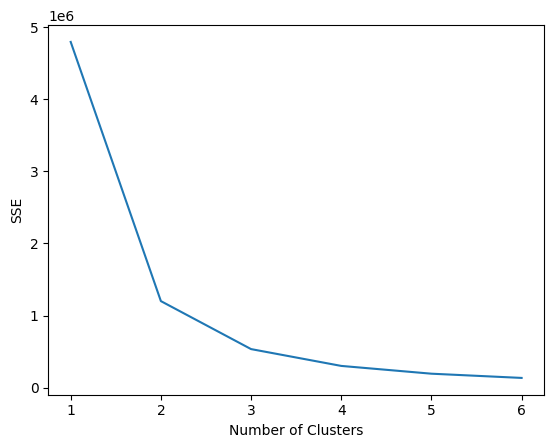

In [18]:
# estimate the number of clusters using a SSE vs. number of clusters graph

numClusters = [1,2,3,4,5,6]
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(df_cho)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

In [19]:
# normalize dataset

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cho)

# PCA with n = 3
pca = PCA(n_components=3).fit(scaled_data)
print('Explained Variance Ratio: ', pca.explained_variance_ratio_)
print('Sum of variance by these 3 components: ', pca.explained_variance_ratio_.cumsum()[2])
print('\nSingular Values: ', pca.singular_values_)

df_cho_3D = pca.transform(scaled_data)

Explained Variance Ratio:  [0.40760319 0.19620284 0.12288723]
Sum of variance by these 3 components:  0.7266932495982633

Singular Values:  [53.21679196 36.92177282 29.22020607]


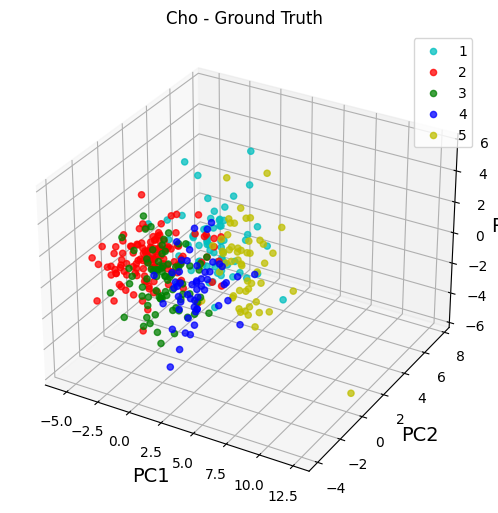

In [20]:
# use PCA to show ground truth label

# set 3 axis
Xax = df_cho_3D[:,0]
Yax = df_cho_3D[:,1]
Zax = df_cho_3D[:,2]

# create figure variables
fig = plt.figure(figsize=(7,5), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
cdict = {0:'m', 1:'c', 2:'r', 3:'g', 4:'b', 5:'y'}
y = df_cho.Ground_Truth_Cluster_ID

# draw figure
fig.patch.set_facecolor('white')
for l in np.unique(y):
 i = np.where(y==l)
 ax.scatter(Xax[i], Yax[i], Zax[i], c=cdict[l], s=20, alpha=0.75, label=l)

ax.set_xlabel("PC1", fontsize=14)
ax.set_ylabel("PC2", fontsize=14)
ax.set_zlabel("PC3", fontsize=14)

plt.title('Cho - Ground Truth')
plt.legend()
plt.show()

c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


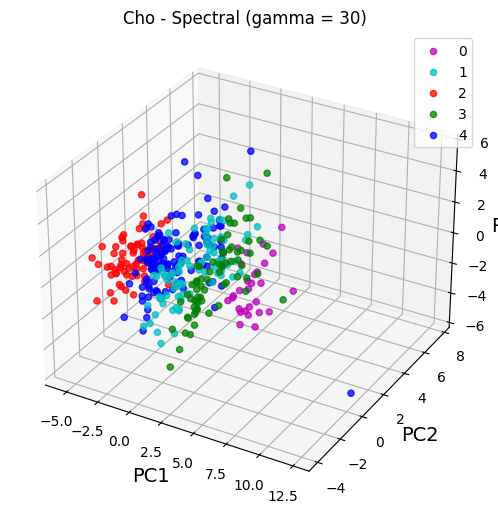

In [21]:
# implement spectral clustering

spectral = cluster.SpectralClustering(n_clusters=5,random_state=1,affinity='rbf',gamma=30)
spectral.fit(df_cho_3D[:, 0:1:2])   # See what happened for spectral results and confusion matrix below with the parameter as input

# create figure variables
fig = plt.figure(figsize=(7,5), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
cdict = {0:'m', 1:'c', 2:'r', 3:'g', 4:'b', 5:'y'}
y = spectral.labels_

# draw figure
fig.patch.set_facecolor('white')
for l in np.unique(y):
 i = np.where(y==l)
 ax.scatter(Xax[i], Yax[i], Zax[i], c=cdict[l], s=20, alpha=0.75, label=l)

ax.set_xlabel("PC1", fontsize=14)
ax.set_ylabel("PC2", fontsize=14)
ax.set_zlabel("PC3", fontsize=14)

plt.title('Cho - Spectral (gamma = 30)')
plt.legend()
plt.show()

In [23]:
# Use external indices for accuracy measurement 

# purity function
def purity_score(truth, predicted):
    contingency_matrix = np.c_[(truth, predicted)]
    # Sum(min(counts per cluster per class)) / total number of data points
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

# set ground truths and predicteds
ground_truth = df_cho.Ground_Truth_Cluster_ID
predicted = spectral.labels_

# calculate external indices
ari = metrics.adjusted_rand_score(ground_truth, predicted)
purity = purity_score(ground_truth, predicted)
nmi = normalized_mutual_info_score(ground_truth, predicted)

# Print results
print("Cho - Spectral")
print("Adjusted Rand Index:", ari)
print("Purity:", purity)
print("Normalized Mutual Information:", nmi)

Cho - Spectral
Adjusted Rand Index: 0.25207374796201043
Purity: 0.0044598612487611496
Normalized Mutual Information: 0.38497848131060664


In [26]:
# Use internal index for accuracy measurement

# get the cluster centers from 
cluster_centers = np.array([df_cho_3D[predicted == i].mean(0) for i in range(spectral.n_clusters)])

# get the sum of SSEs for all clusters
total_sse = np.sum((df_cho_3D - cluster_centers[predicted])**2)

# initialize an empty list to store clusterwise sse
clusterwise_sse = []

# loop over each cluster index from 0 to 4
for i in range(len(df_cho.Ground_Truth_Cluster_ID.unique())):
  # get the data points that belong to this cluster based on labels
  cluster_data = df_cho_3D[predicted == i]
  
  # calculate the squared distance between each point and its cluster center
  squared_distances = np.square(cluster_data - cluster_centers[i])
  
  # sum up the squared distances for this cluster
  sse = np.sum(squared_distances)
  
  # append the sse to the clusterwise sse list
  clusterwise_sse.append(sse)

# print results
print("Cho - Spectral")
print("Clusterwise SSE:", clusterwise_sse)
print("Total SSE:", total_sse)

Cho - Spectral
Clusterwise SSE: [84.72043563659211, 674.1528964843112, 210.17776716716864, 486.1643607733016, 1035.890246701838]
Total SSE: 2491.1057067632114
